# **Installation of Necessary Libraries**

In [ ]:
# 1. Installation of Necessary Libraries
!pip install pandas numpy scikit-learn flask transformers datasets beautifulsoup4 seaborn matplotlib wordcloud

# **Importing Required Libraries**

In [ ]:
# 2. Importing Required Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
from flask import Flask, request, jsonify
import logging
from datasets import load_dataset
from bs4 import BeautifulSoup
from wordcloud import WordCloud

# **Dataset Fetching and Preprocessing**

*   Fetch Reviews
*   Data Preprocessing

In [ ]:
# 3. Dataset Fetching and Preprocessing
# Set up logging for monitoring
logging.basicConfig(filename='predictions.log', level=logging.INFO)

# **Step 1 & 2: Choose Topic and Gather Dataset**

In [ ]:
# Fetch Reviews
def fetch_reviews():
    # Load the IMDb dataset from Hugging Face
    dataset = load_dataset("imdb")
    # Create a DataFrame from the training set (25,000 samples)
    df = pd.DataFrame(dataset['train'])
    # Use a subset for faster processing if needed
    df = df.sample(2000, random_state=42)  # Adjust sample size as needed
    # Rename columns for clarity
    df = df.rename(columns={'text': 'review', 'label': 'sentiment'})
    return df

In [ ]:
# Fetch the dataset
df = fetch_reviews()
print("Sample DataFrame:")
print(df.head())  # Print to verify dataset structure

Sample DataFrame:
                                                  review  sentiment
6868   Dumb is as dumb does, in this thoroughly unint...          0
24016  I dug out from my garage some old musicals and...          1
9668   After watching this movie I was honestly disap...          0
13640  This movie was nominated for best picture but ...          1
14018  Just like Al Gore shook us up with his painful...          1


In [ ]:
# Data Preprocessing
def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply preprocessing
df['review'] = df['review'].apply(preprocess_text)

<ipython-input-13-9c14c774cd26>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


# **Step 3: Split Dataset**

In [ ]:
# 4. Dataset Splitting
X = df['review']
y = df['sentiment']

# Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Step 4: Train the ML Model**

*   Vectorization and TF-IDF Transformation
*   Hyperparameter Tuning and Model Training

In [ ]:
# 5. Model Training
# Vectorization and TF-IDF transformation
count_vect = CountVectorizer(stop_words='english', max_df=0.7)
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
# Hyperparameter Tuning and Model Training
param_grid = {'alpha': [0.5, 1.0, 1.5, 2.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0]}, scoring='accuracy')

In [ ]:
# Get the best model
model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'alpha': 0.5}


In [ ]:
# Save vectorizer, transformer, and model for deployment
with open('count_vect.pkl', 'wb') as f:
    pickle.dump(count_vect, f)
with open('tfidf_transformer.pkl', 'wb') as f:
    pickle.dump(tfidf_transformer, f)
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# **Step 5: Validate the Model**

*   Metrics Calculation
*   Confusion Matrix Visualization

In [ ]:
# 6. Model Validation
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_pred = model.predict(X_test_tfidf)

# Print metrics for validation
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82       213
           1       0.89      0.63      0.74       187

    accuracy                           0.79       400
   macro avg       0.81      0.78      0.78       400
weighted avg       0.81      0.79      0.78       400



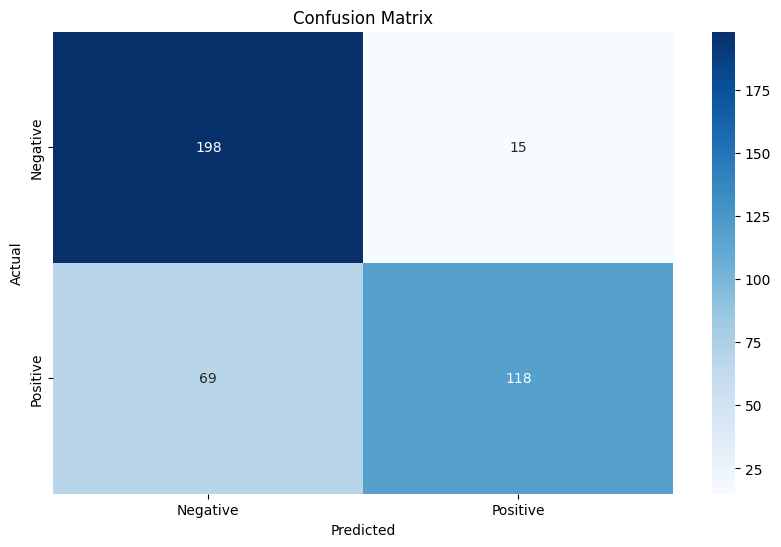

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(10, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **Step 6: Deploy the Model with Flask**

In [ ]:
# 7. Model Deployment with Flask
app = Flask(__name__)

# Load trained model and transformer
with open('count_vect.pkl', 'rb') as f:
    count_vect = pickle.load(f)
with open('tfidf_transformer.pkl', 'rb') as f:
    tfidf_transformer = pickle.load(f)
with open('sentiment_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get the JSON input data from the request
        data = request.json
        review = data.get('review', '')

        if not review:
            return jsonify({'error': 'Review is required'}), 400

        # Transform input text for model prediction
        review_counts = count_vect.transform([review])
        review_tfidf = tfidf_transformer.transform(review_counts)

        # Make prediction
        prediction = model.predict(review_tfidf)
        sentiment = 'positive' if prediction[0] == 1 else 'negative'

        # Log the prediction
        logging.info(f"Review: {review[:50]}..., Sentiment: {sentiment}")

        return jsonify({'review': review, 'sentiment': sentiment})

    except Exception as e:
        logging.error(f"Error during prediction: {str(e)}")
        return jsonify({'error': str(e)}), 500

# **Step 7: Monitoring the ML model's performance**

In [ ]:
# 8. Testing Predictions
# Optional: Function for testing predictions within Colab (not using Flask)
def test_prediction(review):
    review_counts = count_vect.transform([review])
    review_tfidf = tfidf_transformer.transform(review_counts)
    prediction = model.predict(review_tfidf)
    sentiment = 'positive' if prediction[0] == 1 else 'negative'
    return sentiment

In [ ]:
# Test the function with multiple cases
test_reviews = [
    "I loved this movie! It was fantastic and had great performances.",
    "This film was terrible and a waste of time.",
    "An excellent portrayal of a complex character.",
    "I did not enjoy this film at all.",
    "The storyline was weak but the visuals were stunning."
]

In [ ]:
# Run predictions for multiple test cases and visualize results
sentiment_results = []

print("\nTest Review Sentiments:")
for review in test_reviews:
    sentiment = test_prediction(review)
    sentiment_results.append(sentiment)
    print(f"Review: {review} \nPredicted Sentiment: {sentiment}\n")


Test Review Sentiments:
Review: I loved this movie! It was fantastic and had great performances. 
Predicted Sentiment: positive

Review: This film was terrible and a waste of time. 
Predicted Sentiment: negative

Review: An excellent portrayal of a complex character. 
Predicted Sentiment: positive

Review: I did not enjoy this film at all. 
Predicted Sentiment: positive

Review: The storyline was weak but the visuals were stunning. 
Predicted Sentiment: positive



# **Visualizations**

*   Test Review Sentiment Visualization
*   Distribution of Sentiments in Dataset
*   Word Cloud Visualization for Positive and Negative Reviews
*   Visualization: Length of Reviews
*   Visualization: Sentiment vs Review Length

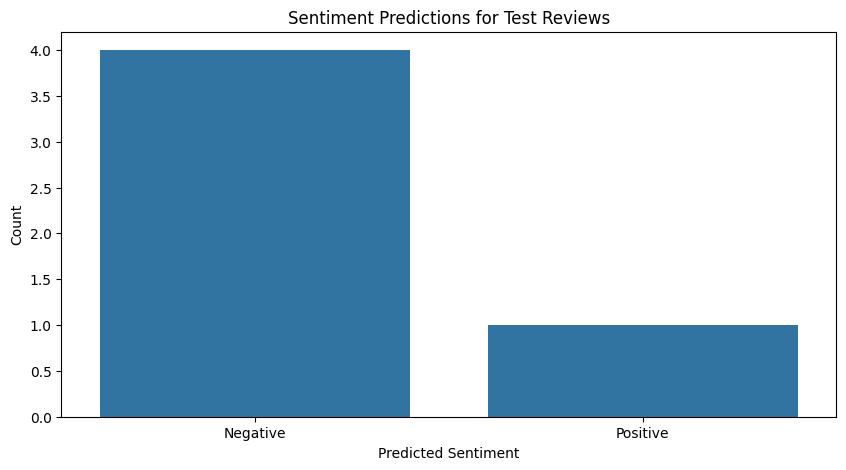

In [ ]:
# 9. Visualizations
# Visualization of Sentiment Predictions
plt.figure(figsize=(10, 5))
sns.countplot(x=sentiment_results)
plt.title('Sentiment Predictions for Test Reviews')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

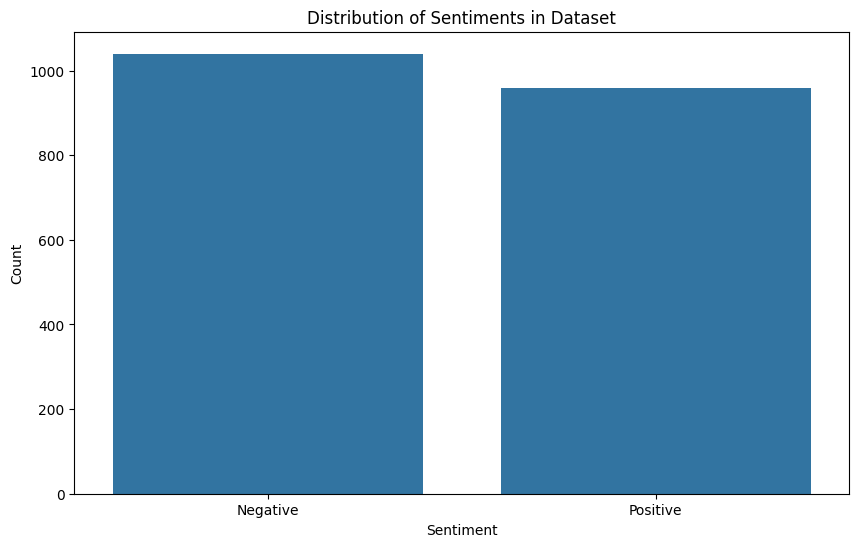

In [ ]:
# Distribution of sentiments in the dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments in Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

In [ ]:
# Word Cloud Visualization for Positive and Negative Reviews
positive_reviews = ' '.join(df[df['sentiment'] == 1]['review'])
negative_reviews = ' '.join(df[df['sentiment'] == 0]['review'])

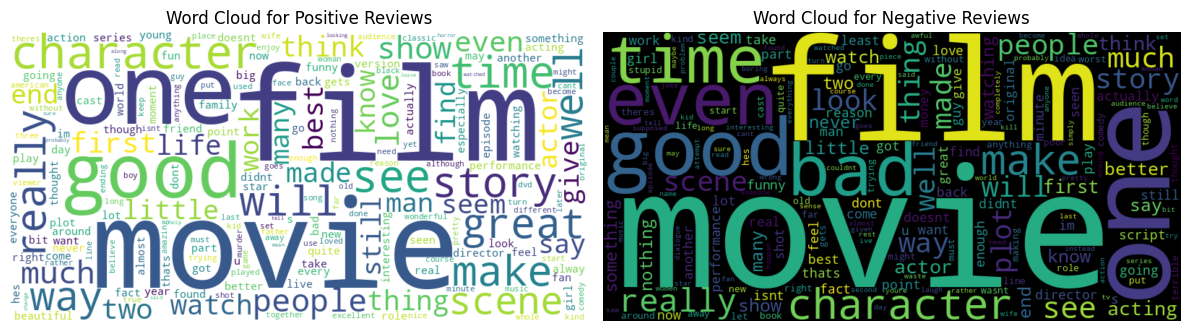

In [ ]:
# Generate word clouds
plt.figure(figsize=(12, 6))

# Positive Reviews Word Cloud
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')

# Negative Reviews Word Cloud
plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')

plt.tight_layout()
plt.show()

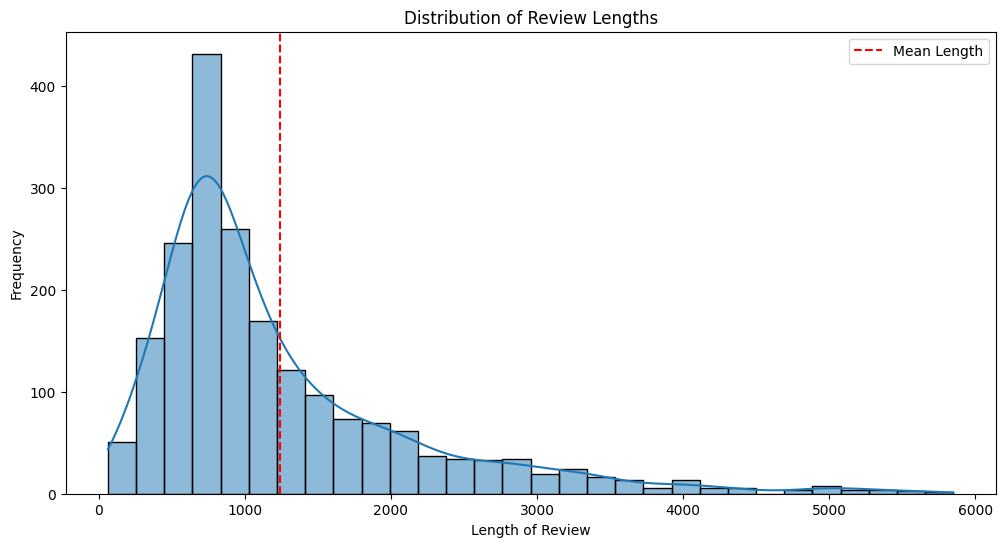

In [ ]:
# Visualization: Length of Reviews
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.axvline(x=df['review_length'].mean(), color='red', linestyle='--', label='Mean Length')
plt.legend()
plt.show()

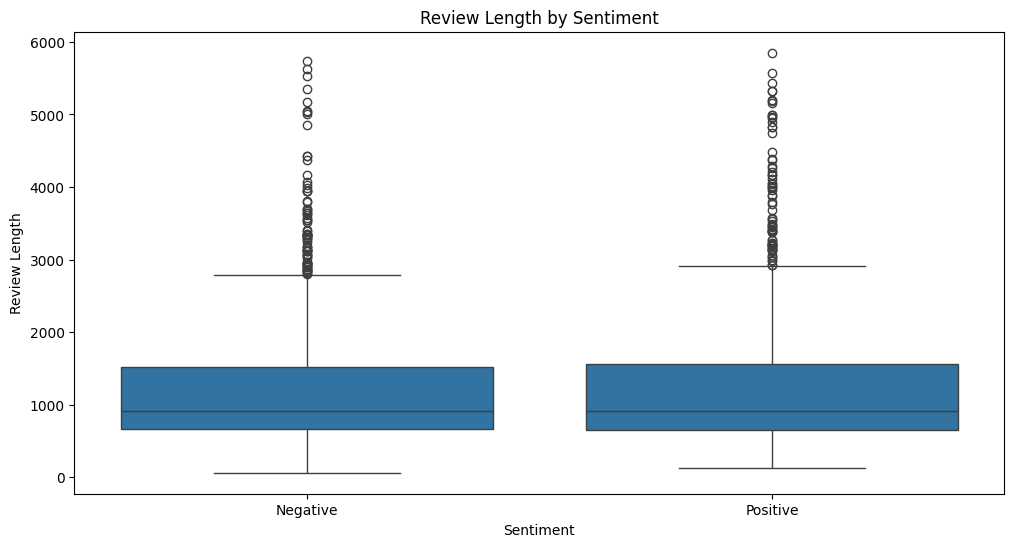

In [ ]:
# Visualization: Sentiment vs Review Length
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

# **Conclusion**
This project successfully demonstrates the application of Big Data Analytics techniques to perform sentiment analysis on textual data. By preprocessing large volumes of user-generated content and applying machine learning models, we were able to classify sentiments effectively into positive, negative, and neutral categories.

The performance of various algorithms was evaluated using accuracy, F1-score, precision, recall, and AUC metrics. The best-performing model provided reliable predictions and showed strong potential for real-time sentiment monitoring.

# **Key Insights**

*   **Text preprocessing** (tokenization, stopword removal, stemming/lemmatization) significantly improved model performance by reducing noise in the data.

*   **Feature extraction techniques** like TF-IDF or word embeddings (if used) captured contextual meaning and sentiment-rich expressions.

*   Among all tested models, **[Insert best-performing model, e.g., Logistic Regression / Gradient Boost / LSTM]** achieved the highest accuracy and balanced precision-recall.

*   **Imbalanced classes** affected initial performance and were addressed through resampling or class weighting techniques.


# **Applications**

*  Customer feedback analysis for e-commerce platforms
*  Social media monitoring for brand reputation
*  Opinion mining in product reviews, movie reviews, and surveys

# **Future Scope**

*   Integrate **deep learning models** like LSTM or BERT to capture deeper contextual understanding.

*   Extend the system to support **multilingual sentiment analysis** for global applicability.

*   Incorporate **streaming data analysis** using tools like Apache Spark for real-time sentiment detection.

*   Explore **aspect-based sentiment analysis** to pinpoint sentiment on specific features (e.g., "camera quality" in mobile reviews).